This notebook is for studying how to use **shape**, **coords** ,and **dims** under un-pooled model.

Using Ex2, Ex3.

Reference:

- pumps

https://www.multibugs.org/examples/latest/Pumps.html

https://areding.github.io/6420-pymc/unit5/Unit5-PumpsMCMC.html?highlight=pm%20beta

- beta-binomial

https://cluhmann.github.io/inferencedata/

https://github.com/fonnesbeck/hierarchical_models_sports_analytics/blob/main/Hierarchical_Models_Sports_Analytics.ipynb


#### kernel : pymc_test3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
import pymc as pm
print(f"Running on PyMC v{pm.__version__}") 
import arviz as az

Running on PyMC v5.8.0


In [2]:
import graphviz

In [11]:
#conda install -c conda-forge python-graphviz

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Yvonne\anaconda3\envs\pymc_test3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.3.1              |       h2466b09_3         8.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.0 MB

The following packages will be UPDATED:

  openssl                                  3.3.1-h2466b09_2 --> 3.3.1-h2466b09_3 



Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


# Start

Yi-Yun Lee Updated on August 26, 2024

## Build a Bayesian model using PyMC

Reference: [PyMC tutorial](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html).

Detailed notes about **distributions**, **sampling methods** and other **PyMC functions** are available in the [API documentation](https://www.pymc.io/projects/docs/en/latest/api.html#api).

**Posterior Inference**

Show statistics of the posterior distribution based 
on the samples. :

- Mean and standard deviation of the posterior.
- 95% credible interval(Highest density interval)
- Monte Carlo Standard Error(MCSE) mean and standard deviation.
- Effective Sample Size(ESS)
- $\widehat{R}$ : good convergence (close to 1)

## EX2. Gamma-Poisson model ... Pumps

MultiBUGS Example: https://www.multibugs.org/examples/latest/Pumps.html

The example relates to **10** power plant pumps. 
The data is given in the following table and gives the number of failures $x_i$ and the length of operation time $t_i$ (in thousands of hours) for each pump.
Pump | $$t_i$$| $$x_i$$|
:----|----:|----:|
1    | 94.50  | 5 |
2    | 15.70  | 1 |
3    | 62.90  | 5 |
4    | 126.00 | 14|
5    |   5.24 | 3 |
6    |  31.40 | 19|
7    | 1.05   | 1 |
8    | 1.05   | 1 |
9    | 2.10   | 4 |
10   | 10.50  | 22|        

**Pumps: conjugate gamma-Poisson hierarchical model**

\begin{align*}
      X_i \mid \theta_i &\sim \text{Poisson}(\theta_i t_i) \\
     \theta_i | \alpha, \beta  &\sim \text{Gamma}(\alpha, \beta) \\
     \alpha &\sim \text{Exponential}(1) \\
     \beta &\sim \text{Gamma}(0.1, 1) 
\end{align*}

10 power plant pumps 
- $X_i$: number of failures,  $i=1,...,10$.
- $𝜃_𝑖$: failure rate for pump $i$,  $i=1,...,10$.
- $𝑡_𝑖$: length of operation time of the pump (in 1000s of hours)

[說明]:

The number of failures xi is assumed to follow a Poisson distribution

A conjugate gamma prior distribution is adopted for the failure rates: THETA_I~GAMMA

Also assume the following prior specification for the hyperparameters α and β

In [3]:
t_data = np.array([94.50, 15.70, 62.90, 126.0, 5.24, 31.4, 1.05, 1.05, 2.10, 10.50])
X_data = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
group_idx = np.arange(10) #Return: Array of evenly spaced values. 

In [4]:
group_idx

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Different between (1.) `shape` argument &`[group_idx]`, and (2.)the different between whether there's `pm.Deterministic()` or not.

- 0. **test [group_idx]**. shape argument + [group_idx]; +(pm.Deterministic())
- 1. **base code**. (shape=10, mu=lambda_poi)+(pm.Deterministic("lambda_poi", theta * times)) 
- 2. **test without pm.Deterministic()**. Directly use (lambda_poi =  theta * times)


#### 1. <font color=#dc143c>[有防呆]</font>
Test if set prior's `shape=5` < likelihood data(number of sample=10)  and didnt given group index `(mu=lambda_poi[group_idx])`

Output: ValueError: Incompatible Elemwise input shapes [(5,), (10,)]

```{Python}

##Test if shape=5 < likelihood data(10)
##and didnt given group indx(mu=lambda_poi[group_idx])
## output: ValueError: Incompatible Elemwise input shapes [(5,), (10,)]
with pm.Model() as m_pumps_idxx:  #container for the model random variables.
## Define the Prior:
    ## 1. Stochastic random variables, 
    ## pm.distribution("variable_name", distribution's parameter, shape or dimension )
    alpha = pm.Exponential("alpha",lam=1)
    beta = pm.Gamma("beta", alpha=0.1, beta=1)
    theta = pm.Gamma("theta", alpha=alpha, beta=beta, shape=5) 
    
    ## 2. Deterministic random variable, 
    ## pm.Deterministic("variable_name", mathematical operation, shape or dimension)
    times = pm.ConstantData("times", t_data)
    lambda_poi = pm.Deterministic("lambda_poi", theta * times)

## Define the Likelihood:
    ## pm.distribution(.., observed = data).
    x = pm.Poisson("x", mu=lambda_poi[group_idx], observed=X_data)
pm.model_to_graphviz(model=m_pumps_idxx)
```

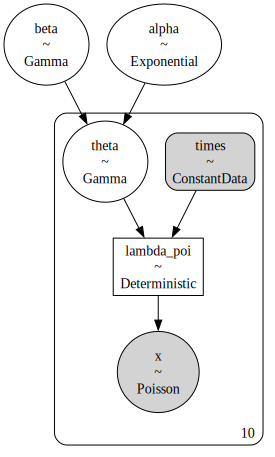

In [5]:
##Creates a new Model object: start_model
with pm.Model() as m_pumps_0idx:  #container for the model random variables.
## Define the Prior:
    ## 1. Stochastic random variables, 
    ## pm.distribution("variable_name", distribution's parameter, shape or dimension )
    alpha = pm.Exponential("alpha",lam=1)
    beta = pm.Gamma("beta", alpha=0.1, beta=1)
    theta = pm.Gamma("theta", alpha=alpha, beta=beta, shape=10) 
    
    ## 2. Deterministic random variable, 
    ## pm.Deterministic("variable_name", mathematical operation, shape or dimension)
    times = pm.ConstantData("times", t_data)
    lambda_poi = pm.Deterministic("lambda_poi", theta * times)

## Define the Likelihood:
    ## pm.distribution(.., observed = data).
    x = pm.Poisson("x", mu=lambda_poi[group_idx], observed=X_data)
pm.model_to_graphviz(model=m_pumps_0idx)

In [6]:
##Creates a new Model object: start_model
with pm.Model() as m_pumps_1base:  #container for the model random variables.
## Define the Prior:
    ## 1. Stochastic random variables, 
    ## pm.distribution("variable_name", distribution's parameter, shape or dimension )
    alpha = pm.Exponential("alpha",lam=1)
    beta = pm.Gamma("beta", alpha=0.1, beta=1)
    theta = pm.Gamma("theta", alpha=alpha, beta=beta, shape=10) 
    
    ## 2. Deterministic random variable, 
    ## pm.Deterministic("variable_name", mathematical operation, shape or dimension)
    times = pm.ConstantData("times", t_data)
    lambda_poi = pm.Deterministic("lambda_poi", theta * times)

## Define the Likelihood:
    ## pm.distribution(.., observed = data).
    x = pm.Poisson("x", mu=lambda_poi, observed=X_data)

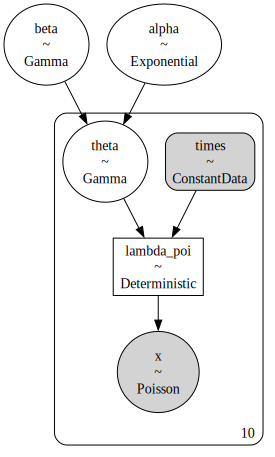

In [7]:
pm.model_to_graphviz(model=m_pumps_1base)

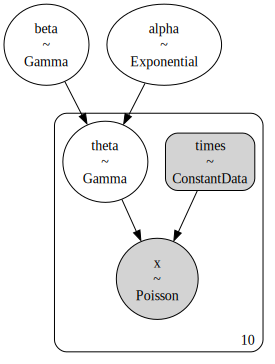

In [8]:
##Creates a new Model object: start_model
#check  the difference between whether lambda_poi =  theta * times

with pm.Model() as m_pumps_2dir:  #container for the model random variables.
## Define the Prior:
    ## 1. Stochastic random variables, 
    ## pm.distribution("variable_name", distribution's parameter, shape or dimension )
    alpha = pm.Exponential("alpha",lam=1)
    beta = pm.Gamma("beta", alpha=0.1, beta=1)
    theta = pm.Gamma("theta", alpha=alpha, beta=beta, shape=10) 
    
    ## 2. Deterministic random variable, 
    ## pm.Deterministic("variable_name", mathematical operation, shape or dimension)
    times = pm.ConstantData("times", t_data)
    lambda_poi =  theta * times

## Define the Likelihood:
    ## pm.distribution(.., observed = data).
    x = pm.Poisson("x", mu=lambda_poi, observed=X_data)
pm.model_to_graphviz(model=m_pumps_2dir)

In [144]:
with m_pumps_0idx:
    i0 = pm.sample(draws=1500, random_seed=101)
with m_pumps_1base:
    i1 = pm.sample(draws=1500, random_seed=101)
with m_pumps_2dir:
    i2 = pm.sample(draws=1500, random_seed=101)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 18 seconds.


In [167]:
az.summary(i0,var_names=["~lambda_poi"], 
           hdi_prob=0.95,round_to=3,kind='stats') 

,mean,sd,hdi_2.5%,hdi_97.5%
alpha,0.695,0.268,0.228,1.224
beta,0.917,0.529,0.073,1.933
theta[0],0.060,0.025,0.018,0.110
theta[1],0.102,0.081,0.001,0.261
theta[2],0.090,0.038,0.024,0.162
theta[3],0.116,0.030,0.060,0.176
theta[4],0.603,0.322,0.096,1.241
theta[5],0.610,0.138,0.354,0.882
theta[6],0.906,0.736,0.005,2.304
theta[7],0.885,0.707,0.000,2.239


In [161]:
az.summary(i1,var_names=["~lambda_poi"], 
           hdi_prob=0.95,round_to=3,kind='stats') 

,mean,sd,hdi_2.5%,hdi_97.5%
alpha,0.704,0.280,0.226,1.266
beta,0.923,0.539,0.113,1.971
theta[0],0.060,0.025,0.016,0.107
theta[1],0.101,0.077,0.000,0.249
theta[2],0.089,0.037,0.024,0.160
theta[3],0.116,0.030,0.058,0.175
theta[4],0.603,0.317,0.090,1.226
theta[5],0.610,0.137,0.365,0.899
theta[6],0.895,0.713,0.004,2.250
theta[7],0.885,0.717,0.012,2.284


In [163]:
az.summary(i2,var_names=["~lambda_poi"], 
           hdi_prob=0.95,round_to=3,kind='stats') 

C:\Users\Yvonne\anaconda3\envs\pymc_test3\Lib\site-packages\arviz\utils.py:134: UserWarning: Items starting with ~: ['lambda_poi'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%
alpha,0.704,0.280,0.226,1.266
beta,0.923,0.539,0.113,1.971
theta[0],0.060,0.025,0.016,0.107
theta[1],0.101,0.077,0.000,0.249
theta[2],0.089,0.037,0.024,0.160
theta[3],0.116,0.030,0.058,0.175
theta[4],0.603,0.317,0.090,1.226
theta[5],0.610,0.137,0.365,0.899
theta[6],0.895,0.713,0.004,2.250
theta[7],0.885,0.717,0.012,2.284


<font color=#dc143c>[*說明*]</font>有些theta(failure rate)比較高，值得注意一下~

In [ ]:
az.plot_posterior(i0, hdi_prob=0.95)
plt.show()

In [ ]:
az.plot_trace(i1)
az.plot_posterior(i1, hdi_prob=0.95)
plt.show()

In [ ]:
## Posterior plot (trace plot)
#az.plot_trace(idata_pumps)
#plt.tight_layout()
#plt.show()

In [ ]:
# Posterior plot (trace plot)
az.plot_trace(i1)
plt.tight_layout()
plt.show()

In [ ]:
from IPython.core.pylabtools import figsize
figsize(8, 6)
az.plot_posterior(i1, var_names=["theta"],hdi_prob=0.95)
plt.show()

In [ ]:
i1.posterior

In [ ]:
i1=pm.sample_posterior_predictive(i1, model=m_pumps_1base,extend_inferencedata=True)

az.plot_ppc(i1, num_pp_samples=1)
#to predict the failure numbers of the new pump given observed data

---

## EX3. Example of Beta-Binomial models

Multicenter trials

- What is the overall success rate? -> **Pooled** model (a single group)
- Are all center-specific effects the same? How to obtain center-specific effect? -> **Unpooled**  and **Hierarchical** model

  What would be the variability? 
- Anything unusual in any clinical center?

| **Hospital** | **Success** |   |   |   | **Hospital** | **Success** |
|:------------:|:-----------:|---|---|---|:------------:|:-----------:|
|       1      |      18     |   |   |   |       9      |      16     |
|       2      |      10     |   |   |   |      10      |      16     |
|       3      |      19     |   |   |   |      11      |      18     |
|       4      |      13     |   |   |   |      12      |      17     |
|       5      |      17     |   |   |   |      13      |      10     |
|       6      |      10     |   |   |   |      14      |      19     |
|       7      |      12     |   |   |   |      15      |      13     |
|       8      |      19     |   |   |   |      16      |      16     |     16 | 16     | 16     |   16   |   16   |   16   |

In [9]:
Y_data = np.array([18,10,19,13,17,10,12,19,16,16,18,17,10,19,13,16]) #Success
k = len(Y_data) #i=1,2,...,16
bb_idx= np.arange(k) #array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
n=20

## EX3. Example of Beta-Binomial models (1)

- Pooled model:


Pool all the data together and estimate the success rate (p) of the hospital as a single big
 group. (Overall success rate)


**Multicenter trials: Beta-Binomial hierarchical model-1**

16家醫院參加某癌症藥物的臨床試驗，每家招募
20人，假設藥效成功率為$p$，請問該藥效能勝過傳
統藥物藥效0.8的機率為多少?

\begin{align*}
      Y_i \mid p &\sim \text{Binomial}(n=20, p) \\
     p \mid \alpha, \beta  &\sim \text{Beta}(\alpha = 3 , \beta = 3) 
\end{align*}

$K=16$ centers
- $Y_i$: number of success ,      $i=1,...,16$
- $p$:  effect p (overall success rate)
- $n$: (n=20) number of patient in each center

In [10]:
#1. beta-binomial model 1
with pm.Model() as beta_bin_m1: 
    ## Priors  
    p = pm.Beta('p', alpha=3, beta=3)
    ## Likelihood  
    y = pm.Binomial('y',n=20, p=p, observed=Y_data)

    idata_bb1 = pm.sample(draws=1000, random_seed=101)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


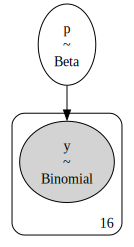

In [11]:
pm.model_to_graphviz(model=beta_bin_m1)

In [12]:
idata_bb1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [255]:
az.summary(idata_bb1, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.755,0.024,0.71,0.804,0.001,0.0,1769.0,2958.0,1.0


Highest-Density Interval (HDI): 

95% credible interval for "p" is [0.710, 0.804], which can be interpreted as the interval within which we believe the parameter falls with 95% probability.

In [ ]:
az.plot_posterior(idata_bb1, hdi_prob=0.95, ref_val=0.8, round_to=3)

請問該藥效能勝過傳統藥物藥效0.8的 機率為多少?

`ref_val`display the percentage below and above the values in ref_val.

**得到prob(p>0.8)=0.029**

## EX3. Example of Beta-Binomial models (2)

- Unpooled model (non-hierarchical):

Study each hospital as a separate group. We can get information  from individual groups

**Multicenter trials: Beta-Binomial hierarchical model-2**

\begin{align*}
      Y_i \mid \textcolor{red}{p_i} &\sim \text{Binomial}(n=20, \textcolor{red}{p_i}) \\
      \textcolor{red}{p_i} \mid \alpha, \beta  &\sim \text{Beta}(\alpha = 3 , \beta = 3)\\ 
\end{align*}

$K=16$ centers
- $Y_i$: number of success ,      $i=1,...,16$ 
- $\color{red}{p_𝑖}$: effect p (success rate) for center $i$,  $i=1,...,16$
- $n$: (n=20) number of patients in each center

16家醫院參加某癌症藥物的臨床試驗，每家招募
20人，假設藥效成功率為$p_i$，請問該藥效能勝過傳
統藥物藥效0.8的機率為多少?

In [13]:
#DataFrame example:
hostpital_name=['h01','h02','h03','h04','h05','h06','h07','h08','h09',
                'h10','h11','h12','h13','h14','h15','h16']
y_list=[18,10,19,13,17,10,12,19,16,16,18,17,10,19,13,16]

bb_df = {"Hospital":pd.Series(hostpital_name, dtype='category'),
        "Success": y_list}
bb_df = pd.DataFrame(bb_df)

In [14]:
 #since number of y_i = group of hospital
k=len( bb_df) #16 
h_idx=np.arange(k) #array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [15]:
bb_df

,Hospital,Success
0,h01,18
1,h02,10
2,h03,19
3,h04,13
4,h05,17
5,h06,10
6,h07,12
7,h08,19
8,h09,16
9,h10,16


In [16]:
#DataFrame example:
hostpital_name=['h01','h02','h03','h04','h05','h06','h07','h08','h09',
                'h10','h11','h12','h13','h14','h15','h16',
               'h01','h02','h03','h04','h05','h06','h07','h08','h09',
                'h10','h11','h12','h13','h14','h15','h16']
y_list=[18,10,19,13,17,10,12,19,16,16,18,17,10,19,13,16,
       13,11,20,12,13,13,11,18,15,14,19,19,13,16,12,17]

bb_df = {"Hospital":pd.Series(hostpital_name, dtype='category'),
        "Success": y_list}
bb_df = pd.DataFrame(bb_df)
#Index: Array, dtype=int8 0,1,2,3
Hosp_idx = bb_df.Hospital.cat.codes.values 
#Label: Array, object (category)['h1', 'h10', 'h11',...]
Hosp_labels = bb_df.Hospital.cat.categories 

In [17]:
bb_df

,Hospital,Success
0,h01,18
1,h02,10
2,h03,19
3,h04,13
4,h05,17
5,h06,10
6,h07,12
7,h08,19
8,h09,16
9,h10,16


In [18]:
## another method

In [19]:
#categorical codes
hn_idx,hn_codes = pd.factorize(bb_df["Hospital"])
n_hn = len(hn_codes) #shape=n_hospital groups

In [20]:
hn_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [21]:
hn_codes

CategoricalIndex(['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                  'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16'],
                 categories=['h01', 'h02', 'h03', 'h04', ..., 'h13', 'h14', 'h15', 'h16'], ordered=False, dtype='category')

In [22]:
#another end

In [23]:
#Index: Array, dtype=int8 0,1,2,3
Hosp_idx = bb_df.Hospital.cat.codes.values 
#Label: Array, object (category)['h1', 'h10', 'h11',...]
Hosp_labels = bb_df.Hospital.cat.categories  


h_idx,h_codes = pd.factorize(bb_df["Hospital"])
n_hn = len(hn_codes) #shape=n_hospital groups
k=n_hn 

In [24]:
k

16

In [25]:
h_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [26]:
Hosp_idx 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [27]:
Hosp_labels

Index(['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10',
       'h11', 'h12', 'h13', 'h14', 'h15', 'h16'],
      dtype='object')

In [28]:
hn_codes

CategoricalIndex(['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                  'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16'],
                 categories=['h01', 'h02', 'h03', 'h04', ..., 'h13', 'h14', 'h15', 'h16'], ordered=False, dtype='category')

## start test bb2 model

In [29]:
### Shapes

In [30]:
#test for shape=16, p[h_idx]
with pm.Model(coords=coords) as bb2_s1: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, shape=k) ##k=16#32
    # Likelihood
    y = pm.Binomial('y', n=20, p=p[h_idx],
                    observed = y_list)
    ibb2s1 = pm.sample(draws=500, random_seed=101)
pm.model_to_graphviz(model=bb2_s1)

NameError: name 'coords' is not defined

In [87]:
#test for shape=16, p with no group_idx>>error when different dimension 
with pm.Model(coords=coords) as bb2_s0: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, shape=k) ##k=16
    # Likelihood
    y = pm.Binomial('y', n=20, p=p,
                    observed = y_list)
    ibb2s0 = pm.sample(draws=500, random_seed=101)
pm.model_to_graphviz(model=bb2_s0)

ValueError: Incompatible Elemwise input shapes [(32,), (16,)]

In [290]:
### start dims

In [ ]:
Hosp_labels

In [ ]:
h_idx

In [ ]:
np.arange(len(bb_df))

<font color=#dc143c>[**測試結果**]</font>

<font color=#dc143c>**y-> 32 samples, Hospital->16**

<font color=#dc143c>- Likelihood y(=32) **cannot have dimension "hospital"**, which is shape=16

<font color=#dc143c>- y's p, **needs to be given group_index(h_idx)** in order to understand which group they are from.
```
coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df)),
          "Hospital_flat":Hosp_labels[Hosp_idx]}
```

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


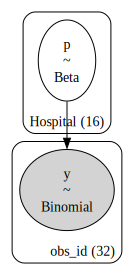

In [31]:
#d0>> OK
#y: dims="obs_id"32 + p[Hosp_idx]
coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df))}
with pm.Model(coords=coords) as bb2_d0: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, dims="Hospital")
    # Likelihood
    y = pm.Binomial('y', n=20, p=p[h_idx],
                    observed = bb_df.Success.values,
                    dims="obs_id")
    ibb2d0 = pm.sample(draws=500, random_seed=101)
    idata_bb2 = pm.sample(draws=1000, random_seed=101)
pm.model_to_graphviz(model=bb2_d0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 15 seconds.


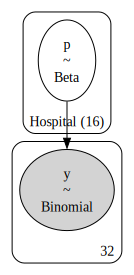

In [32]:
#d3>> ok, 
## withot dims for y + given group_index p[h_idx]
 

#y: dims="obs_id" + p[group_idx]
coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df)),
          "Hospital_flat":Hosp_labels[Hosp_idx]}
with pm.Model(coords=coords) as bb2_d3: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, dims="Hospital")
    # Likelihood
    y = pm.Binomial('y', n=20, p=p[h_idx],
                    observed = bb_df.Success.values)
    ibb2d3 = pm.sample(draws=500, random_seed=101)
pm.model_to_graphviz(model=bb2_d3)

In [422]:
#d1 >>Error, pm.sample()
#test y: dims="Hospital" +p[Hosp_idx]
##ValueError: conflicting sizes for dimension 'Hospital': length 32 on the data but length 16 on coordinate 'Hospital'

coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df))}
with pm.Model(coords=coords) as bb2_d1: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, dims="Hospital")
    # Likelihood
    y = pm.Binomial('y', n=20, p=p[h_idx],
                    observed = bb_df.Success.values,
                    dims="Hospital")
    ibb2d1 = pm.sample(draws=500, random_seed=101)
pm.model_to_graphviz(model=bb2_d1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16 seconds.


ValueError: conflicting sizes for dimension 'Hospital': length 32 on the data but length 16 on coordinate 'Hospital'

In [425]:
#d2 >>Error, ValueError: Incompatible Elemwise input shapes [(32,), (16,)]
#with y(=32)> dims="hospital"=16; 
#Need to assign p[h_idx], so that the model can know which hospital i given this y_i 

#y: dims="obs_id" + p !! p no group_idx
coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df))}
with pm.Model(coords=coords) as bb2_d2: 
    # Prior
    p = pm.Beta('p', alpha=3, beta=3, dims="Hospital")
    # Likelihood
    y = pm.Binomial('y', n=20, p=p,
                    observed = bb_df.Success.values,
                    dims="obs_id")
    ibb2d2 = pm.sample(draws=500, random_seed=101)
pm.model_to_graphviz(model=bb2_d2)

ValueError: Incompatible Elemwise input shapes [(32,), (16,)]

---

#### test HEIRARCHICAL start

In [33]:
#old vers. Hierarchical
coords = {"Hospital": Hosp_labels, 
          "Hospital_flat":Hosp_labels[Hosp_idx]}
with pm.Model(coords=coords) as beta_bin_m5tt: 
    # Hyper parameters
    theta= pm.Beta('theta', alpha=6, beta=3)
    omega= pm.Beta('omega', alpha=1, beta=3)

    alpha=pm.Deterministic("alpha", theta/omega)
    beta=pm.Deterministic("beta", (1-theta)/omega)

    ##target: #其實我不太懂why要額外寫，是為了好觀察trace?嗎
    var_p=pm.Deterministic("var_p",theta*(1-theta)*omega)
                           
    # Parameters for p
    p = pm.Beta('p', alpha=alpha, beta=beta, dims="Hospital") #dims

    #[Hosp_idx]=0123以codes對應dims="pos"
    y = pm.Binomial('y', n=20, p=p, dims="Hospital_flat", observed=bb_df.Success.values) #### dims="Hospital"!!!!!!!
    #it3 = pm.sample(draws=500, random_seed=101)#

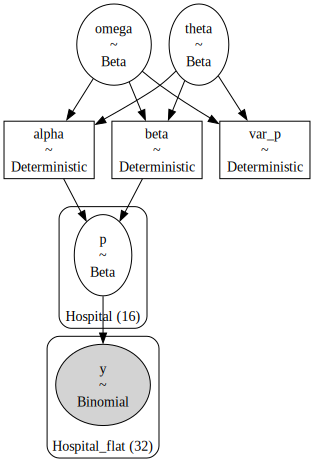

In [34]:
pm.model_to_graphviz(model=beta_bin_m5tt) 

In [35]:
#old vers.
coords = {"Hospital": Hosp_labels}
with pm.Model(coords=coords) as beta_bin_m4tt: 
    # Hyper parameters
    theta= pm.Beta('theta', alpha=6, beta=3)
    omega= pm.Beta('omega', alpha=1, beta=3)

    alpha=pm.Deterministic("alpha", theta/omega)
    beta=pm.Deterministic("beta", (1-theta)/omega)

    ##target: #其實我不太懂why要額外寫，是為了好觀察trace?嗎
    var_p=pm.Deterministic("var_p",theta*(1-theta)*omega)
                           
    # Parameters for p
    p = pm.Beta('p', alpha=alpha, beta=beta, shape=16) #dims

    #[Hosp_idx]=0123以codes對應dims="pos"
    y = pm.Binomial('y', n=20, p=p[Hosp_idx], observed=bb_df.Success.values) #### dims="Hospital"!!!!!!!
    it3 = pm.sample(draws=500, random_seed=101)#

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, omega, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


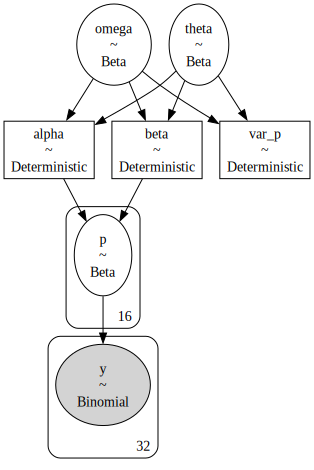

In [36]:
pm.model_to_graphviz(model=beta_bin_m4tt) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, omega, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


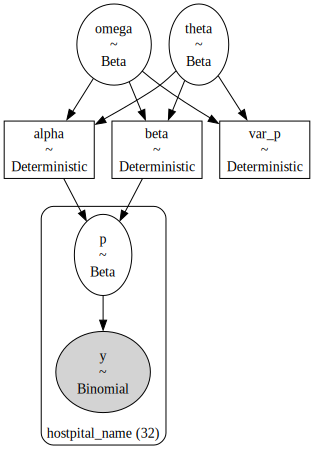

In [37]:
#if still un-pooled
coords = {"hostpital_name": hostpital_name,
          "hos_flat":Hosp_labels[Hosp_idx]}
with pm.Model(coords=coords) as beta_bin_w2_001: 
    # Hyper parameters
    theta= pm.Beta('theta', alpha=6, beta=3)
    omega= pm.Beta('omega', alpha=1, beta=3)

    alpha=pm.Deterministic("alpha", theta/omega)
    beta=pm.Deterministic("beta", (1-theta)/omega)

    ##target: #其實我不太懂why要額外寫，是為了好觀察trace?嗎
    var_p=pm.Deterministic("var_p",theta*(1-theta)*omega)
                           
    # Parameters for p
    p = pm.Beta('p', alpha=alpha, beta=beta, dims="hostpital_name") #dims

    #[Hosp_idx]=0123以codes對應dims="pos"
    #######hos_flat=Hosp_labels[Hosp_idx]
    y = pm.Binomial('y', n=20, p=p,dims="hostpital_name", observed=bb_df.Success.values) #### dims="Hospital"!!!!!!!
    i2_001 = pm.sample(draws=500, random_seed=101)#
pm.model_to_graphviz(model=beta_bin_w2_001) 

#### test end

In [98]:
az.summary(idata_bb2, hdi_prob=0.95)#.round(2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[h01],0.738,0.066,0.610,0.865,0.001,0.001,6839.0,3321.0,1.0
p[h02],0.522,0.073,0.377,0.658,0.001,0.001,10002.0,2632.0,1.0
p[h03],0.913,0.041,0.831,0.982,0.000,0.000,6806.0,2970.0,1.0
p[h04],0.610,0.070,0.481,0.754,0.001,0.001,8486.0,3014.0,1.0
p[h05],0.716,0.066,0.582,0.837,0.001,0.001,7041.0,3068.0,1.0
p[h06],0.565,0.074,0.420,0.714,0.001,0.001,8151.0,2751.0,1.0
p[h07],0.564,0.070,0.427,0.703,0.001,0.001,7071.0,2998.0,1.0
p[h08],0.870,0.048,0.780,0.961,0.001,0.000,6628.0,2727.0,1.0
p[h09],0.740,0.063,0.610,0.853,0.001,0.000,8123.0,2993.0,1.0
p[h10],0.716,0.067,0.586,0.847,0.001,0.001,7179.0,2697.0,1.0


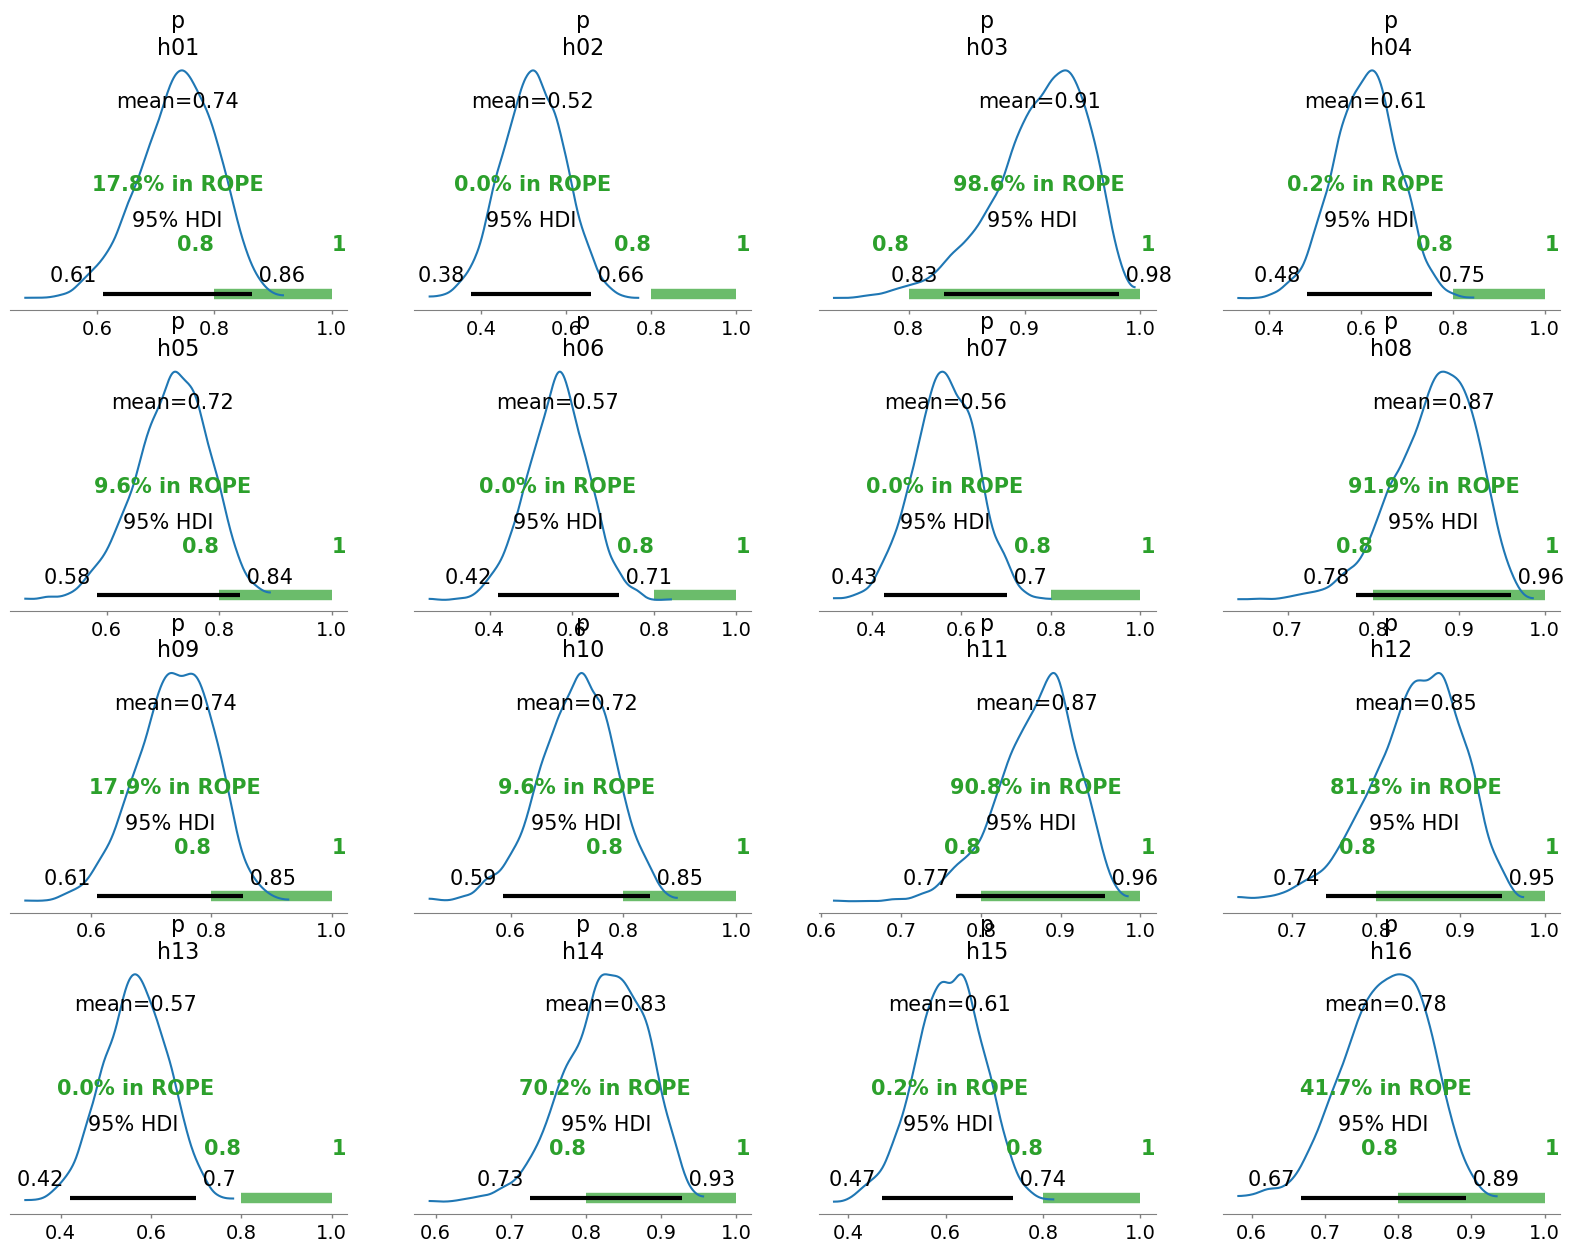

In [99]:
#Region Of Practical Equivalence (ROPE)
#The ROPE is shown as a thick light-gray line
az.plot_posterior(idata_bb2, rope=[0.8, 1], 
                  hdi_prob=0.95, 
                  figsize=(20, 15)) 
plt.show()

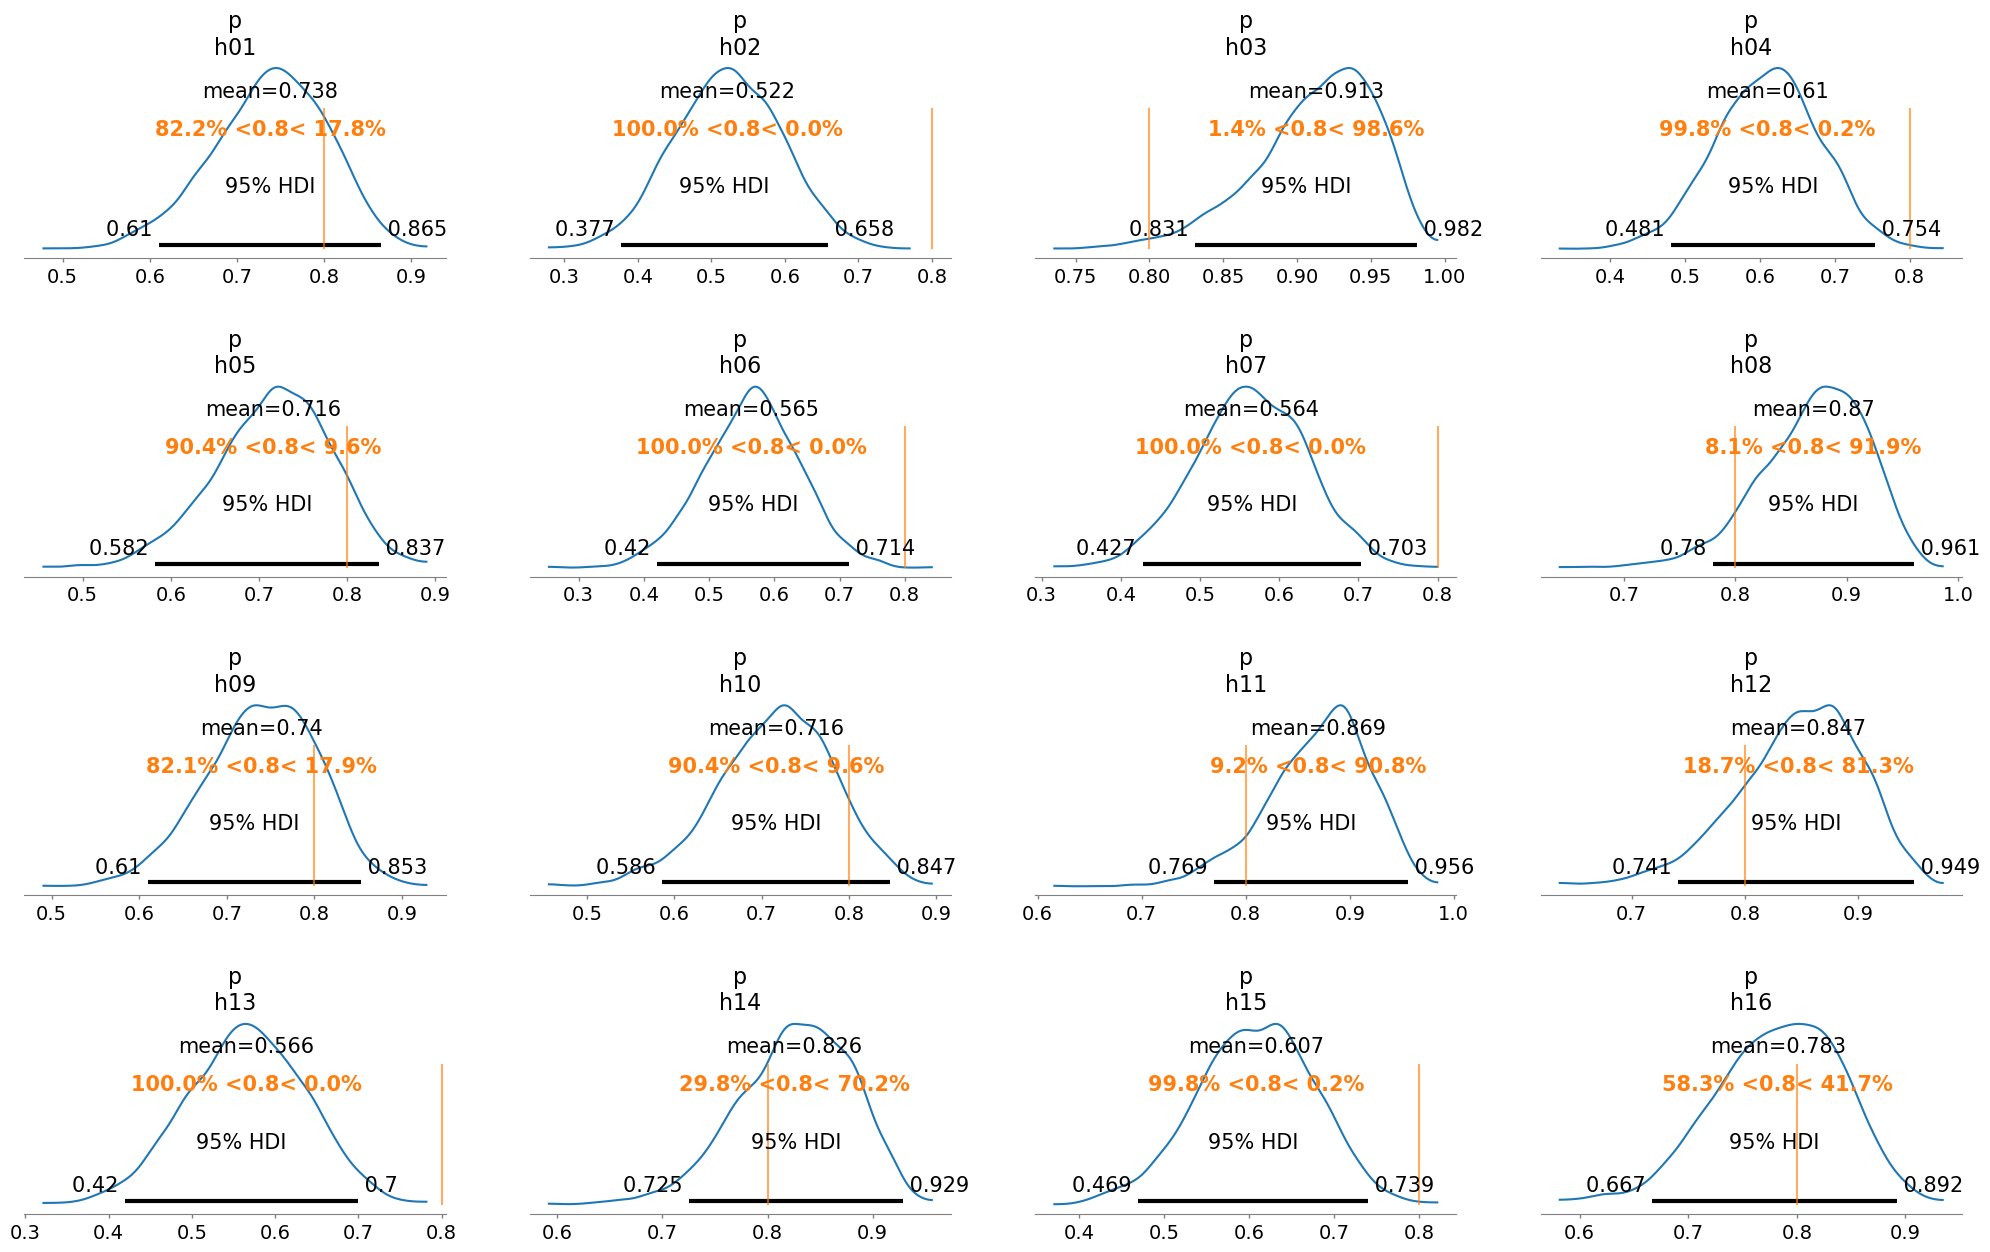

In [100]:
#請問該藥效能勝過傳統藥物藥效0.8的 機率為多少?
#ref_val=display the percentage below and above the values in ref_val.
az.plot_posterior(idata_bb2, hdi_prob=0.95, ref_val=0.8, round_to=3,figsize=(25, 15))
plt.subplots_adjust(hspace=0.6)#add some subplot upper space
plt.show()

## EX3. Example of Beta-Binomial models (3)

- Hierarchical model

The model allow estimates at the group level but with the restriction that they all belong to a larger group or population. 

**Multicenter trials: Beta-Binomial hierarchical model-3 (2-parameter)**

16家醫院參加某癌症藥物的臨床試驗，每家招募20人，假設藥效成功率為p𝑖，請問假設藥效成功率的平均效果及變異為多少? (see P6 Lecture 2.5)

Likelihood  & prior:
\begin{align*}
      Y_i \mid \textcolor{red}{p_i} &\sim \text{Binomial}(n=20, \textcolor{red}{p_i}) \\
      \textcolor{red}{p_i} \mid \alpha, \beta  &\sim \text{Beta}(\alpha , \beta)\\ \\
\end{align*}
Hyper prior:
\begin{align*}
      \textcolor{blue}{\theta = \alpha / (\alpha + \beta)}  &\sim \text{Beta}( 6, 3)\\
      \textcolor{blue}{\omega = 1 / (\alpha + \beta)}  &\sim \text{Beta}( 1, 3)
\end{align*}





其中，"Target"為
\begin{align*}
E(p_i) &= \theta \\
Var(p_i)&= \theta (1-\theta) \omega
\end{align*}

也可以從$\theta$,$\omega$回推(寫在pm.Deterministic)
\begin{align*}
\alpha &= \theta / \omega \\
\beta &= (1-\theta) / \omega
\end{align*}

$K=16$ centers
- $Y_i$: number of success ,      $i=1,...,16$ 
- $p_𝑖$: effect p (success rate) for center $i$,  $i=1,...,16$
- $n$: (n=20) number of patient in each center5)

In [ ]:
coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df)),
          "Hospital_flat":Hosp_labels[Hosp_idx]}

In [38]:
#old vers.
coords = {"Hospital": Hosp_labels,"obs_id": np.arange(len(bb_df))}
with pm.Model(coords=coords) as beta_bin_m3: 
    # Hyper parameters
    theta= pm.Beta('theta', alpha=6, beta=3)
    omega= pm.Beta('omega', alpha=1, beta=3)

    alpha=pm.Deterministic("alpha", theta/omega)
    beta=pm.Deterministic("beta", (1-theta)/omega)

    ##target: #其實我不太懂why要額外寫，是為了好觀察trace?嗎
    var_p=pm.Deterministic("var_p",theta*(1-theta)*omega)
                           
    # Parameters for p
    p = pm.Beta('p', alpha=alpha, beta=beta, dims="Hospital") #dims

    #[Hosp_idx]=0123以codes對應dims="pos"
    y = pm.Binomial('y', n=20, p=p[Hosp_idx], observed=bb_df.Success.values,dims="obs_id") #### dims="Hospital"!!!!!!!
    idata_bb3 = pm.sample(draws=500, random_seed=101)#

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, omega, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


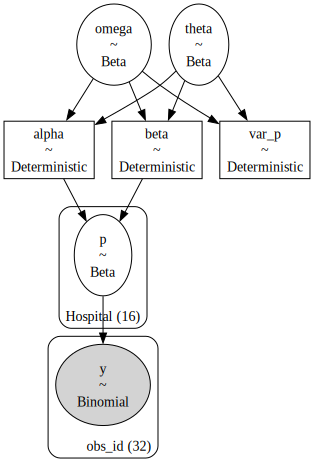

In [39]:
pm.model_to_graphviz(model=beta_bin_m3)

In [46]:
az.summary(idata_bb3, hdi_prob=0.95).round(2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.74,0.04,0.66,0.82,0.00,0.00,2980.0,1583.0,1.00
omega,0.14,0.06,0.04,0.27,0.00,0.00,1537.0,1320.0,1.00
p[h01],0.77,0.06,0.64,0.88,0.00,0.00,4644.0,1286.0,1.00
p[h02],0.56,0.07,0.42,0.70,0.00,0.00,3318.0,1479.0,1.00
p[h03],0.94,0.04,0.86,0.99,0.00,0.00,2236.0,940.0,1.00
p[h04],0.65,0.07,0.52,0.78,0.00,0.00,4068.0,1355.0,1.00
p[h05],0.75,0.06,0.62,0.86,0.00,0.00,3882.0,1204.0,1.00
p[h06],0.60,0.07,0.46,0.74,0.00,0.00,3141.0,1545.0,1.00
p[h07],0.60,0.08,0.46,0.74,0.00,0.00,3454.0,1750.0,1.00
p[h08],0.89,0.04,0.81,0.97,0.00,0.00,3741.0,1400.0,1.00


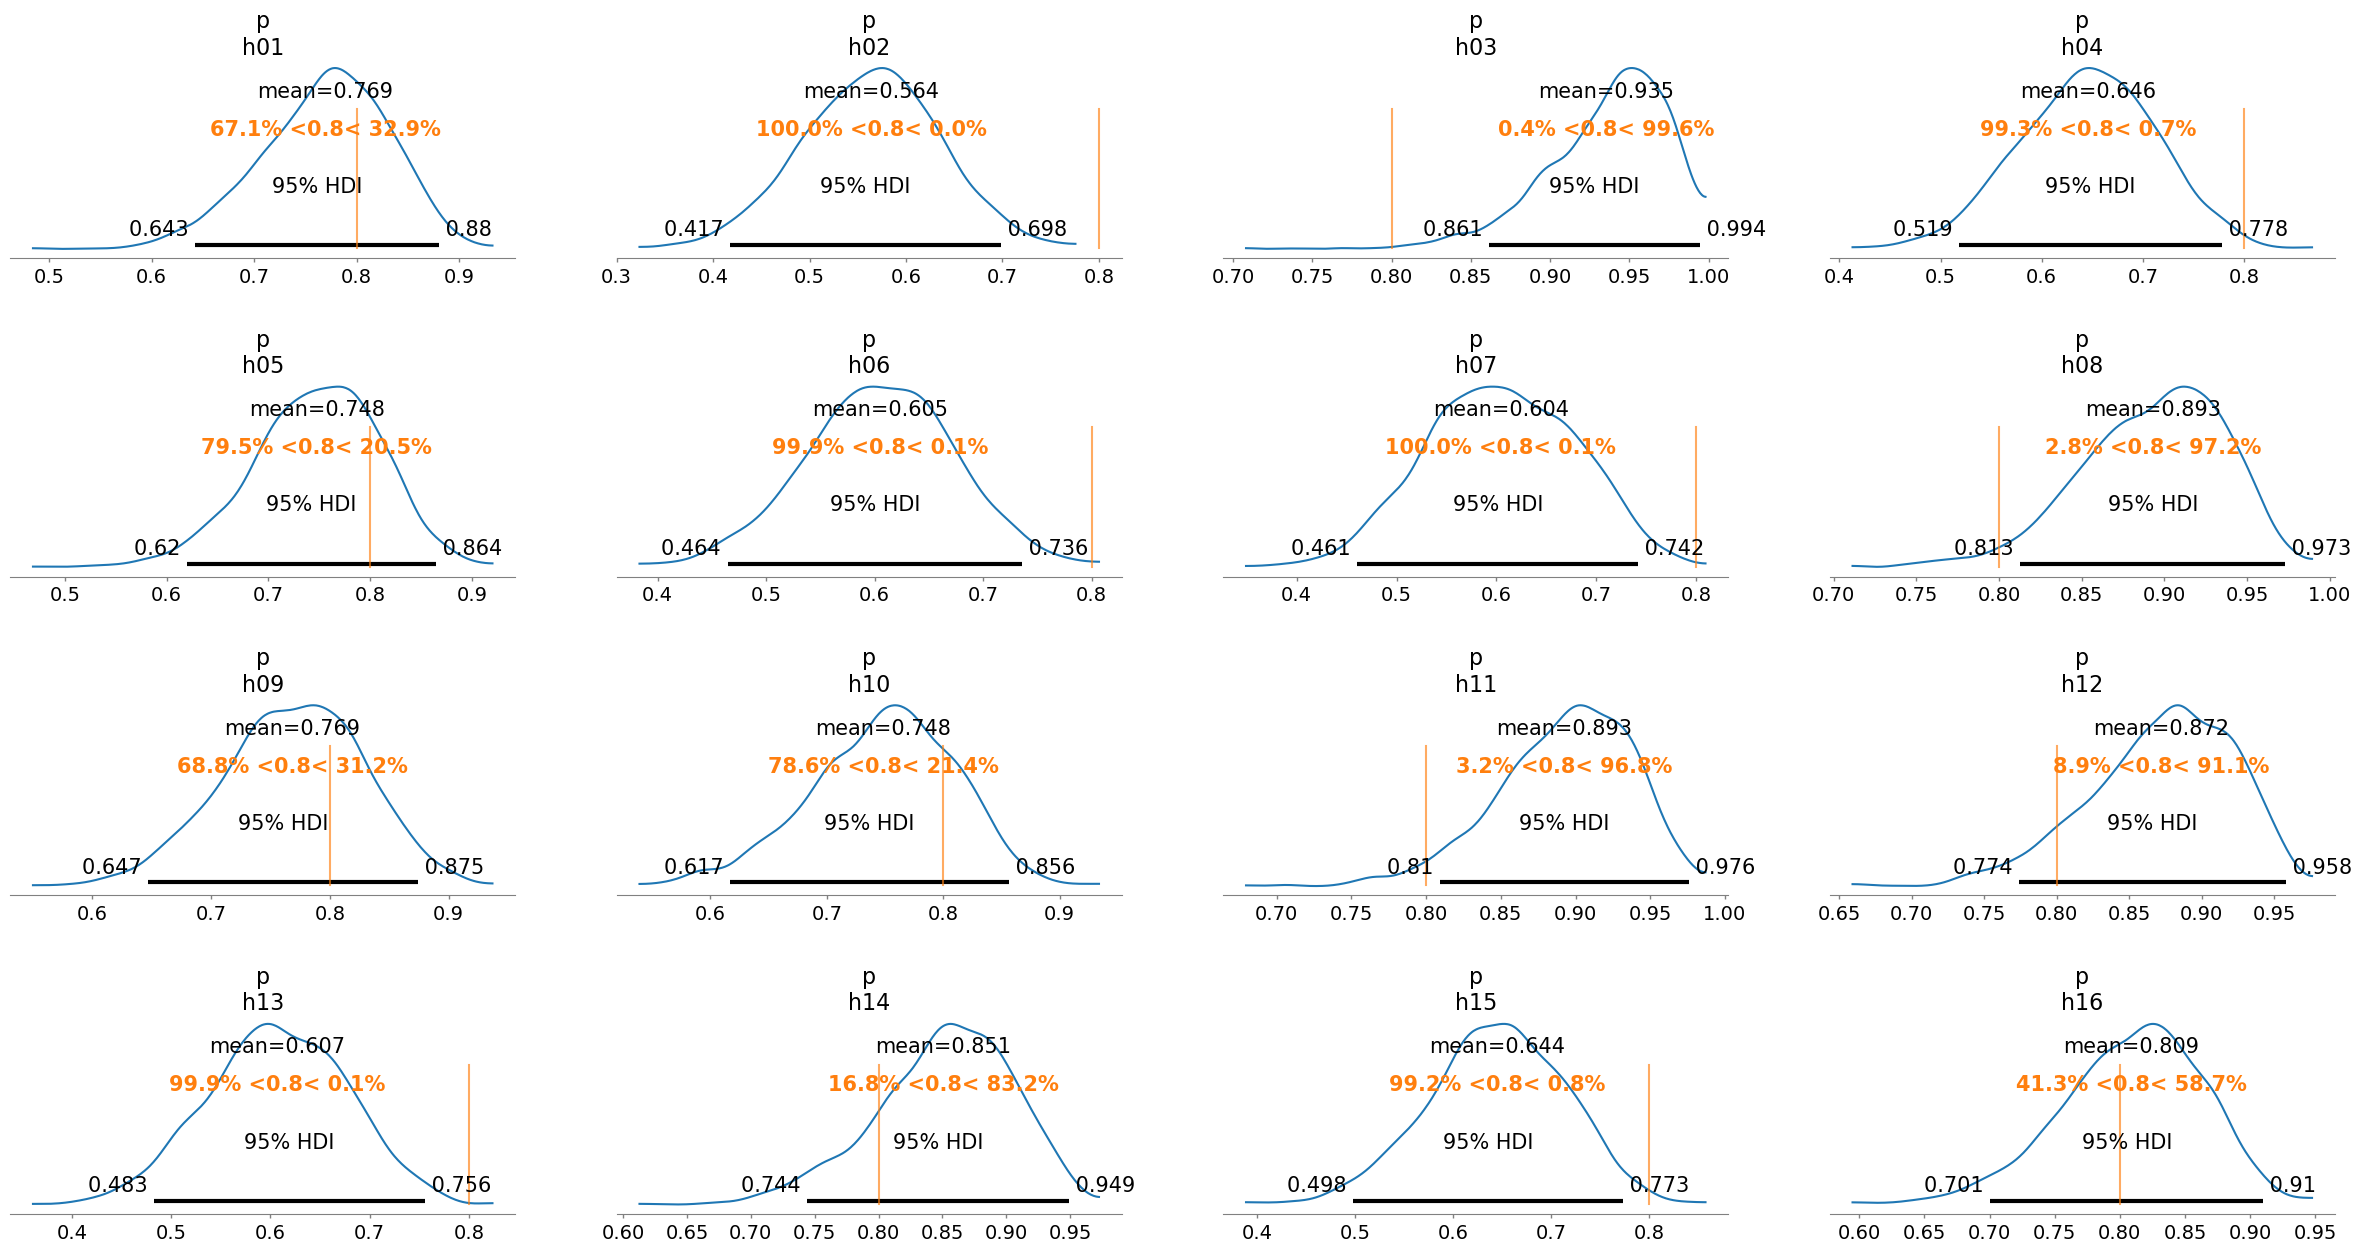

In [47]:
#請問該藥效能勝過傳統藥物藥效0.8的 機率為多少?
#ref_val=display the percentage below and above the values in ref_val.
az.plot_posterior(idata_bb3, hdi_prob=0.95, ref_val=0.8, round_to=3,
                  var_names=["p"],
                  figsize=(30, 15))
plt.subplots_adjust(hspace=0.6)#add some subplot upper space

plt.show()

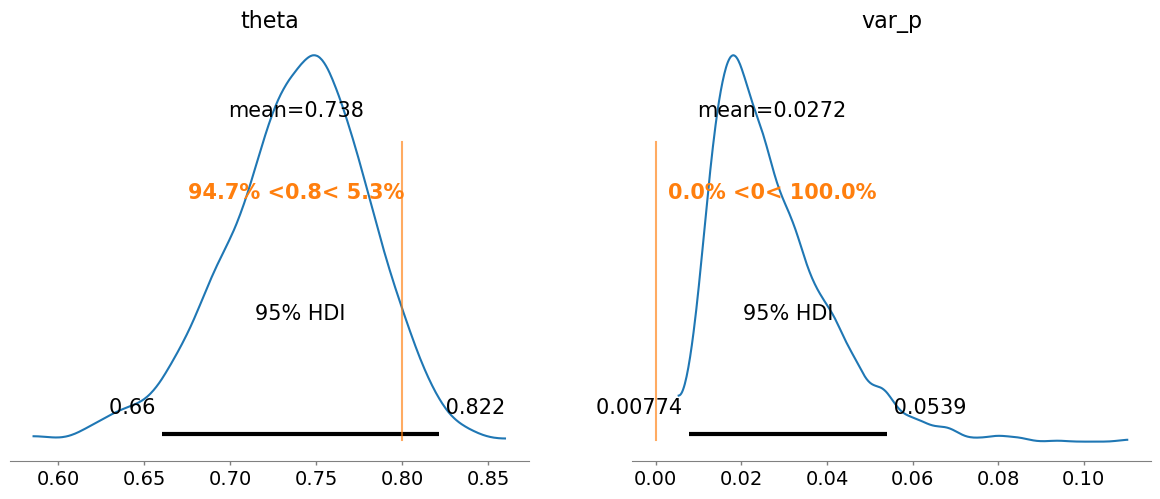

In [48]:
az.plot_posterior(idata_bb3, hdi_prob=0.95, ref_val=[0.8,0], round_to=3,
                  var_names=["theta","var_p"])
plt.show()

## EX3. Example of Beta-Binomial models (4)

- Hierarchical model

The model allow estimates at the group level but with the restriction that they all belong to a larger group or population. 

**Multicenter trials: Beta-Binomial hierarchical model-4**

16家醫院參加某癌症藥物的臨床試驗，每家招募20人，假設藥效成功率為p𝑖，請問假設藥效成功率的平均效果及變異為多少? (see P6 Lecture 2.5)

Likelihood  & prior:
\begin{align*}
      Y_i \mid \textcolor{red}{p_i} &\sim \text{Binomial}(n=20, \textcolor{red}{p_i}) \\
      \textcolor{red}{p_i} \mid \alpha, \beta  &\sim \text{Beta}(\alpha , \beta)\\ 
\end{align*} 
Hyper prior:
\begin{align*}
      \alpha  &\sim \text{Gamma}( 8, 2)\\
      \beta &\sim \text{Exponential}(0.1)
\end{align*}



Target為
\begin{align*}
E(p_i) &= \alpha /(\alpha + \beta) \\
Var(p_i) &= \alpha \beta / (\alpha + \beta)^2(\alpha + \beta +1)
\end{align*}

$K=16$ centers
- $Y_i$: number of success ,      $i=1,...,16$ 
- $p_𝑖$: effect p (success rate) for center $i$,  $i=1,...,16$
- $n$: (n=20) number of patient in each center

In [103]:
coords = {"Hospital": Hosp_labels,
          "h_id":h_idx,
         "obs_id": np.arange(len(bb_df)),
          "Hospital_flat":Hosp_labels[Hosp_idx]}

In [40]:
coords = {"Hospital": Hosp_labels}
with pm.Model(coords=coords) as beta_bin_m4: 
    # Hyper parameters (hyper-prior)
    alpha= pm.Gamma('alpha', alpha=8, beta=2)
    beta= pm.Exponential('beta',lam=0.1) 

    ##target: #其實我不太懂為啥要額外寫，是為了好觀察trace?嗎
    E_p=pm.Deterministic("E_p", alpha/(alpha+beta))
    var_p=pm.Deterministic("var_p", (alpha*beta) / ((alpha+beta)*(alpha+beta)*(alpha+beta+1))
                          )
                           
    # Parameters for p
    #prior
    p = pm.Beta('p', alpha=alpha, beta=beta, dims="Hospital")

    #likelihood
    y = pm.Binomial('y', n=20, p=p[Hosp_idx], observed=bb_df.Success.values)
    
    idata_bb4 = pm.sample(draws=500, random_seed=101)#, random_seed=4591

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


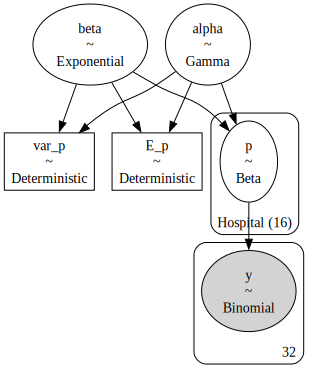

In [41]:
pm.model_to_graphviz(model=beta_bin_m4)

In [52]:
az.summary(idata_bb4, hdi_prob=0.95).round(3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.034,1.325,2.610,7.717,0.029,0.020,2125.0,1512.0,1.00
beta,1.828,0.529,0.903,2.848,0.013,0.009,1693.0,1722.0,1.00
p[h01],0.768,0.063,0.637,0.881,0.001,0.001,4678.0,1341.0,1.00
p[h02],0.557,0.072,0.417,0.692,0.001,0.001,4772.0,1474.0,1.00
p[h03],0.940,0.037,0.868,0.996,0.001,0.000,2522.0,1361.0,1.00
p[h04],0.641,0.073,0.490,0.770,0.001,0.001,3342.0,1185.0,1.00
p[h05],0.747,0.063,0.633,0.878,0.001,0.001,4754.0,1492.0,1.00
p[h06],0.599,0.073,0.459,0.732,0.001,0.001,4618.0,1418.0,1.00
p[h07],0.598,0.070,0.473,0.740,0.001,0.001,3766.0,1608.0,1.00
p[h08],0.897,0.045,0.805,0.971,0.001,0.001,3673.0,1210.0,1.00


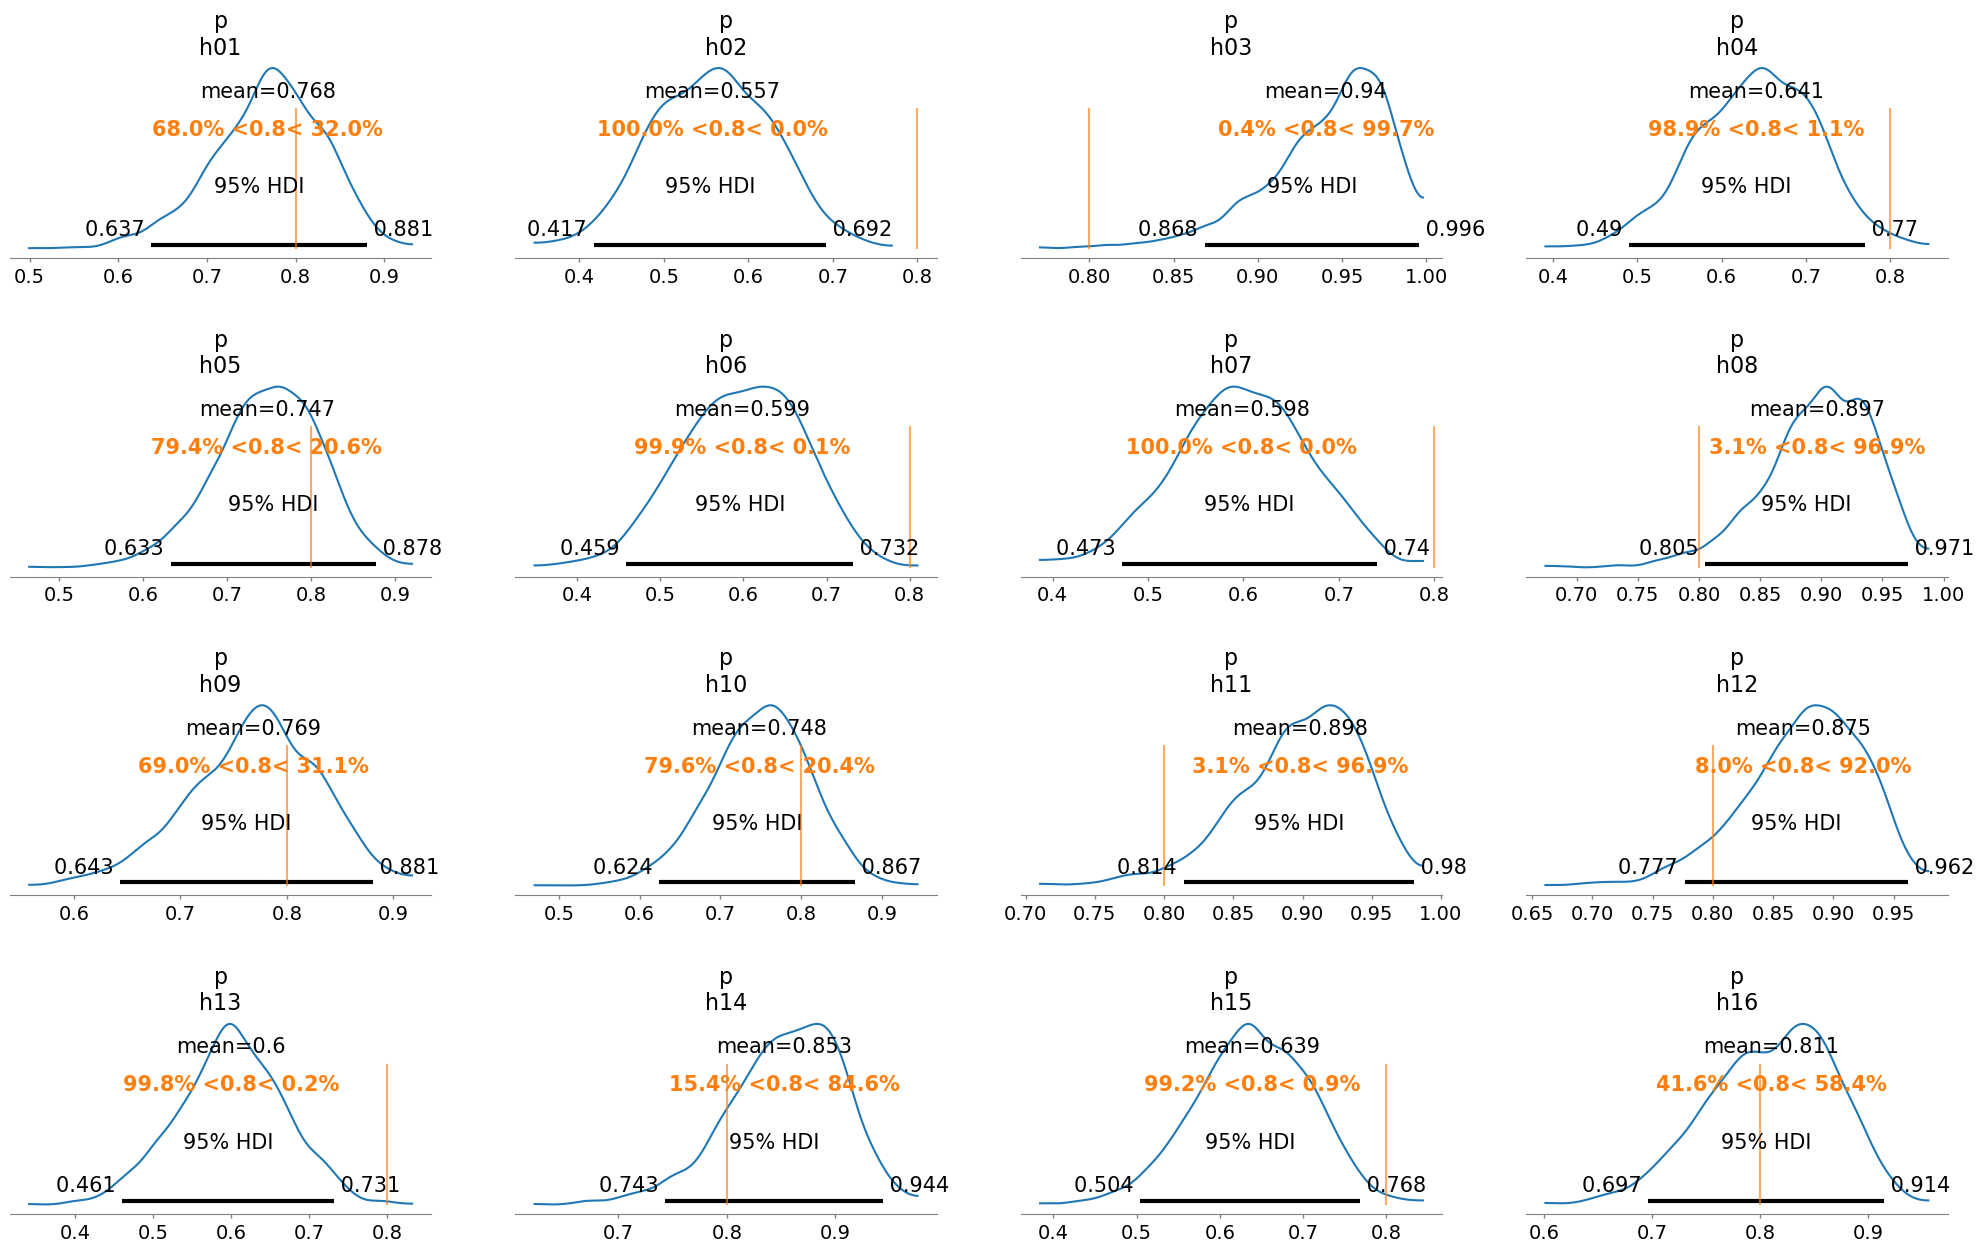

In [53]:
#請問該藥效能勝過傳統藥物藥效0.8的 機率為多少?
#ref_val=display the percentage below and above the values in ref_val.
az.plot_posterior(idata_bb4, hdi_prob=0.95, ref_val=0.8, round_to=3,figsize=(25, 15),var_names=["p"])
plt.subplots_adjust(hspace=0.6)#add some subplot upper space

plt.show()

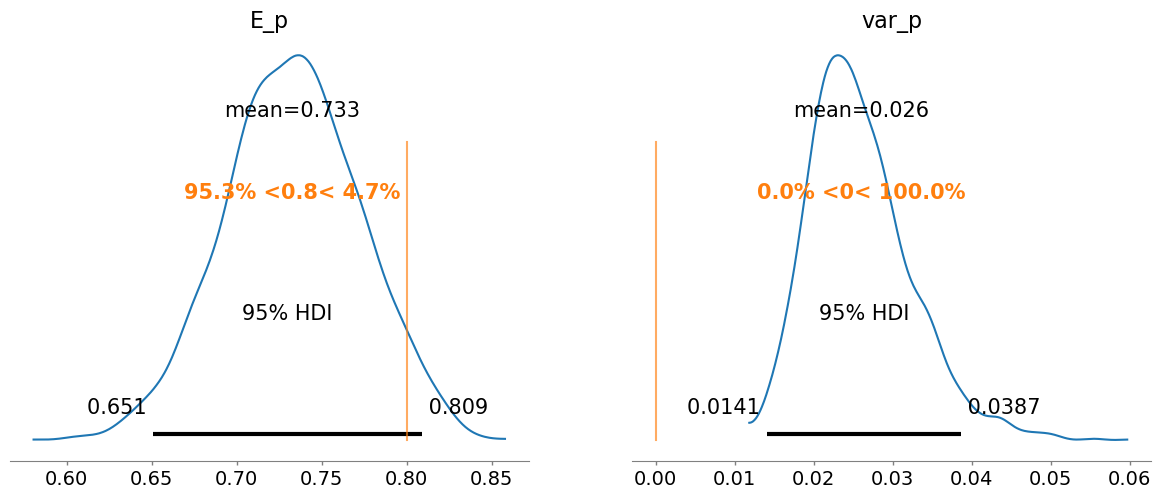

In [54]:
az.plot_posterior(idata_bb4, hdi_prob=0.95, ref_val=[0.8,0], round_to=3,
                  var_names=["E_p","var_p"])
plt.show()

az.plot_trace(idata_bb4)
plt.show()